
## Guia indice de este documento:

1. <span style="color:blue">Evaluación de Optimización en Computación Clásica vs. Cuántica para N=3</span>
    - <span style="color:blue">Objetivos</span>
2. <span style="color:blue">Definición de la Función Objetivo</span>
3. <span style="color:blue">Enfoque de búsqueda de puntos validos.</span>
4. <span style="color:blue">Búsqueda de Puntos Válidos</span>
5. <span style="color:blue">Análisis de Resultados</span>
6. <span style="color:blue">Discusión de Resultados del Código Anterior</span>
7. <span style="color:blue">Código de Análisis</span>
    - <span style="color:blue">Cálculo de Cobertura del Espacio de Parámetros</span>
    - <span style="color:blue">Análisis de Distancias entre Puntos</span>
    - <span style="color:blue">Análisis de Componentes Principales (PCA)</span>
    - <span style="color:blue">Cálculo de Discrepancia</span>
    - <span style="color:blue">Generación y Validación de Polinomios de Chebyshev</span>
    - <span style="color:blue">Visualizaciones</span>
8. <span style="color:blue">Optimización Cuántica Simulada</span>
    - <span style="color:blue">Visualización de la Función Objetivo</span>
    - <span style="color:blue">Creación del Modelo QUBO</span>
    - <span style="color:blue">Resolución y Visualización de Resultados</span>
9. <span style="color:blue">Optimización Clásica de la Función</span>
10. <span style="color:blue">Discusión</span>
11. <span style="color:blue">Conclusiones</span>


# Evaluación de Optimización en Computación Clásica vs. Cuántica para N=3 o sea con la funcion de 4 variables f=f(x1, x2, x3, x4) (el siguiente paso y el final sera hacer todo para N=53)

Este notebook presenta un el estudio sobre la optimización de la funcion a optimizar utilizando métodos de computación clásica y cuántica. Se analizarán el proceso, la validez de las comparaciones entre ambos enfoques, en el enfoque cuantico se busca tener una base solida para validar la aproximación de la función mediante polinomios de Chebyshev. Además, se estudiara el método de búsqueda de puntos

Este documento pretende mostrar en resumen del proceso completo del trabajo.

**Objetivos:**

- Hacer una comparativa entre los enfoques clasico y cuantico.
- Implementar y validar el método de búsqueda de puntos.
- Aproximar la función original, con los puntos encontrados, a los polinomios de Chebyshev.
- Analizar tiempos de ejecución y errores en el enfoque cuantico.
- Probar codigo generalizdo para en paso siguiente manejar funcion con `2 x 53 - 1` variables.

In [ ]:
from math import sin, tan, sqrt, pow, asin, atanh, log, exp, pi, nan
import numpy as np
import sympy as sp
import itertools
import time
import random
from collections import deque, defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize, differential_evolution
import pandas as pd

## Definición de la Función Objetivo

Se define la funcion original con N=3, `fun(x1, x2, x3, x4)`.

Esta funcion majea cualquie numero de variables segun se configure el valor de "N".

In [ ]:
N=3
# Table, pag: 6
Cx_0 = 0.014 # -
k = 0.09 # -
Cz_max = 0.7 # -
S_REF = 120 # m^2 [L^2]
η = 0.06/3600 # kg(N.s)^-1 [L^-1 T]  seria lo inverso a una velocidad, verdad?
Zp_I = 10000 * 0.3048 # m [L]
Zp_F = 36000 * 0.3048 # m [L]

π = pi

m_I = 60000 # kg [M]
CAS_I = 250*0.5144444444444445 # m/s [LT^-1]
VMO = 350*0.5144444444444445 # m/s [LT^-1]
MMO = 0.82 # -
M_CRZ = 0.80 # -
L = 400000 # m [L]
s_F=L

Vz_min = 1.52400 # m/s
g_0 = 9.80665 # m/s^2 [LT^-2]
CI = 30/60 # kg/s [M T^-1] #documento

# Defs, pag: 3
m_0 = m_I # kg [M]
t_0 = 0 # s [T]
s_0 = 0 # m [L]
λ_0 = 1 # -

# Defs (2) pag: 4
Ts_0 = 288.15 # K
ρ_0 = 1.225 # kg.m^-3
L_z = -0.0065 # K.m^-1
g_0 = 9.80665 # m/s^2 [LT^-2]
R = 287.05287 # N.m.kg^-1.K^-1
α_0 = -g_0/R/L_z # "ecuacion"

def Fun(x):
    array_entrada = np.array(x)

    x1, x2 = np.array_split(array_entrada, 2)
    N=len (x1)+1
    x1 = np.array(x1)
    x2 = np.array(x2)

    def Zp(i): # m
        return Zp_I + i*(Zp_F - Zp_I)/(N)

    def F_N_MCL(i):
        return 140000 - 2.53*Zp(i)/0.3048 # N

    def ρ(i):
        return ρ_0 * ((Ts_0 + L_z*Zp(i))/Ts_0)**(α_0 - 1) # kg/m^3

    def M(l):
        return v[l]/sqrt(1.4*R*((Ts_0) + L_z*Zp(l)))

    def CAS(l):
        arg = (7*R*Ts_0) * (((Ts_0/(Ts_0 + L_z*Zp(l)))**-α_0 *
                                 (pow((1 + (v[l]**2/(7*R*(Ts_0 + L_z*Zp(l))))),3.5) - 1) + 1)**(1/3.5) - 1)

        if arg < 0:
            return nan
        else:
            return sqrt(arg)


    TAS_I = sqrt    (7*R*(Ts_0 + L_z*Zp_I) * ((((Ts_0 + L_z*Zp_I)/Ts_0)**-α_0 * ((1 + CAS_I**2/(7*R*Ts_0))**3.5 - 1) + 1)**(1/3.5) - 1))

    v_0 = TAS_I
    Cz_0 = m_0*g_0/(0.5*ρ(0)*v_0**2*S_REF)
    γ_0 = asin  ((F_N_MCL(0)-0.5*ρ(0)*v_0**2*S_REF*(Cx_0 + k*Cz_0))/(m_0*g_0))
    ρ_F = ρ_0 * ((Ts_0 + L_z*Zp_F)/Ts_0)**(α_0-1)
    v_F = M_CRZ * sqrt(1.4*R*(Ts_0 + L_z*Zp_F)) #m/s


    def Cz_ip(i):
        return (2 * m[i+1] * sin(γ[i+1]) * ((2 * γ[i+1] - 2 * γ[i]) / (Zp(i+1) - Zp(i)) - (ρ(i) * S_REF * Cz[i]) / (2 * m[i] * sin(γ[i])) \
                                            + g_0 / (v[i+1]**2 * tan(γ[i+1])) + g_0 / (v[i]**2 * tan(γ[i]))))/(ρ(i+1) * S_REF)


    def m_ip(i):

        A = (v[i+1]-v[i])/(Zp(i+1)-Zp(i))

        L = (-g_0/v[i+1] + (λ[i]*F_N_MCL(i))/(m[i]*v[i]*sin(γ[i]))
            - (0.5*ρ(i)*v[i]*S_REF*(Cx_0+k*Cz[i]**2))/(m[i]*sin(γ[i]))
            - g_0/v[i])

        H = (4*sin(γ[i+1])/(ρ(i+1)*S_REF)) * ((γ[i+1]-γ[i])/(Zp(i+1)-Zp(i)) +
            g_0/(2*v[i+1]**2*tan(γ[i+1])) - (ρ(i)*S_REF*Cz[i])/(4*m[i]*sin(γ[i])) +
            g_0/(2*v[i]**2*tan(γ[i])))

        I = (-2*v[i+1]*sin(γ[i+1])/(η*F_N_MCL(i+1))) * (1/(Zp(i+1)-Zp(i)))

        J = (2*v[i+1]*sin(γ[i+1])/(η*F_N_MCL(i+1))) * (m[i]/(Zp(i+1)-Zp(i))) - (v[i+1]*sin(γ[i+1])*λ[i]*F_N_MCL(i))/(F_N_MCL(i+1)*v[i]*sin(γ[i]))

        numerator_1 = (-2.0*A*v[i+1]*sin(γ[i+1]) + F_N_MCL(i+1)*I + L*v[i+1]*sin(γ[i+1]))
        numerator_2 = (2.0*sqrt(A**2*v[i+1]**2*sin(γ[i+1])**2 - A*F_N_MCL(i+1)*I*v[i+1]*sin(γ[i+1]) -
                                    A*L*v[i+1]**2*sin(γ[i+1])**2 - 0.25*Cx_0*H**2*S_REF**2*k*ρ(i+1)**2*v[i+1]**4 +
                                    0.25*F_N_MCL(i+1)**2*I**2 + 0.5*F_N_MCL(i+1)*H**2*J*S_REF*k*ρ(i+1)*v[i+1]**2 +
                                    0.5*F_N_MCL(i+1)*I*L*v[i+1]*sin(γ[i+1]) + 0.25*L**2*v[i+1]**2*sin(γ[i+1])**2))
        denominator = H**2*S_REF*k*ρ(i+1)*v[i+1]**2

        m_i_plus_1_positive = (numerator_1 + numerator_2)/denominator
        return m_i_plus_1_positive


    def s_ip(i):
        return s[i] + 0.5 * (Zp(i+1) / tan(γ[i+1]) + Zp(i+1) / tan(γ[i]) - Zp(i) / tan(γ[i+1]) - Zp(i) / tan(γ[i]))

    def t_ip(i):
        return t[i] + 0.5 * ((Zp(i+1) - Zp(i)) / (v[i+1] * sin(γ[i+1])) + (Zp(i+1) - Zp(i)) / (v[i] * sin(γ[i])))

    def λ_ip(i):
        term1 = -2 * (v[i+1] * sin(γ[i+1])) / (η * F_N_MCL(i+1))
        term2 = (m[i+1] - m[i]) / (Zp(i+1) - Zp(i))
        term3 = (v[i+1] * sin(γ[i+1]) * λ[i] * F_N_MCL(i)) / (F_N_MCL(i+1) * v[i] * sin(γ[i]))
        return (term1 * term2) - term3


    def λ_ip(i):
        term1 = -2 * (v[i+1] * sin(γ[i+1])) / (η * F_N_MCL(i+1))
        term2 = (m[i+1] - m[i]) / (Zp(i+1) - Zp(i))
        term3 = (v[i+1] * sin(γ[i+1]) * λ[i] * F_N_MCL(i)) / (F_N_MCL(i+1) * v[i] * sin(γ[i]))
        return (term1 * term2) - term3




    def Θ(N_,_𝑣,γ_):
        global N, v, γ, m, s, t, 𝜆, Cz, v_, P
        N=N_ ; P=True ; v=_𝑣; γ=γ_

        m = [m_0]; s=[s_0]; t=[t_0]; 𝜆=[𝜆_0]; Cz=[Cz_0]
        Cz_i = Cz_0
        for i in range (0, N-1, 1):
            if len(v) <= (i+1) or v[i+1]*sin(γ[i+1]) < Vz_min or CAS(i+1) > VMO : P=False; N = i+1; break
            m.append(m_ip(i))
            Cz.append(Cz_ip (i))
            𝜆.append(𝜆_ip(i))
            s.append(s_ip(i))
            t.append(t_ip(i))


            if (𝜆[i+1] > 1 or 𝜆[i+1] < 0) or (Cz[i+1] > Cz_max or M(i+1) > MMO):
                P=False; break
        return

    def A():
        return (-ρ_F * S_REF * Cx_0) / (2 * m[N-1]) - (6 * k * m[N-1] * g_0**2) / (ρ_F * S_REF * v[N-1]**4)

    def B():
        return (16 * k * m[N-1] * g_0**2) / (ρ_F * S_REF * v[N-1]**3)

    def C():
        return (F_N_MCL(N-1) / m[N-1]) - (12 * k * m[N-1] * g_0**2) / (ρ_F * S_REF * v[N-1]**2)

    def D(A, B, C):
        return (B**2 - 4 * A * C)**0.5

    def t_B():
        global kuo45789
        kuo45789 = (2/D(A(), B(), C())) * (atanh((2*A()*v[N-1] + B())/D(A(), B(), C())) - atanh((2*A()*v_F + B())/D(A(), B(), C())))
        return t[N-1] + kuo45789

    def m_B():
        return m[N-1] - η * 𝜆[N-1] * F_N_MCL(N-1) * (t_B() - t[N-1])

    def s_B():
        return s[N-1] + (1/A()) * log((D(A(), B(), C())-2*A()*v_F-B())/(D(A(), B(), C())-2*A()*v[N-1]-B())) - (B()+D(A(), B(), C()))/(2*A()) * (t_B() - t[N-1])

    def m_F():
        return m_B() * exp((-2 * η * g_0 * sqrt(k * Cx_0) / v_F) * (s_F - s_B()))

    def t_F():
        return t_B() + (s_F - s_B()) / v_F

    def φ(v,γ):
        Θ(N,v,γ)
        if P == True:
            return  -m_F()  + CI*(t_B() - s_B()/v_F)
        else:
            return nan
    return φ(np.concatenate(([v_0], x1)), np.concatenate(([γ_0], x2*π/180)))

def FF(x):
    a = -Fun(x)
    if a > 0:
        return a
    else:
        return 70000 # Valor mas alto en la funcion

num_variables = (N - 1) * 2
def fun(*args):

    if len(args) != num_variables:
        raise ValueError(f"Se esperaban {num_variables} variables, pero se recibieron {len(args)}")

    # Si todas las entradas son escalares, llamar directamente a FF
    if all(np.isscalar(arg) for arg in args):
        return FF(args)
    else:
        # Combinar las entradas en una matriz de coordenadas
        coords = np.stack(args, axis=-1)
        # Vectorizar la función FF
        vectorized_funn = np.vectorize(FF, signature=f'({num_variables})->()')
        return vectorized_funn(coords)


## Enfoque de búsqueda de puntos validos.

La función buscar_puntos implementa un algoritmo de búsqueda sistemática en un espacio multidimensional para identificar puntos que cumplen con criterios específicos definidos por la función objetivo. Inicialmente, la función toma un punto de inicio y define las distancias de exploración para cada dimensión, lo que determina el paso con el que se generarán los puntos vecinos al punto valido dado. Se utilizan estructuras de datos como listas y conjuntos para mantener un registro de los puntos válidos, rechazados, explorados y pendientes, anteriormente se uso un enfoque hexagonal pero los tiempos de busqueda son mucho mayores. El conjunto de puntos pendientes se inicializa con el punto inicial, y a medida que se exploran los puntos, se actualizan estos conjuntos para evitar redundancias y asegurar una cobertura eficiente del espacio de búsqueda.

El núcleo del algoritmo reside en la generación y evaluación de vecinos de cada punto actual. Para cada iteración, se seleccionan hasta n puntos del conjunto de pendientes basándose en los parámetros mp (preferencia por vecinos de puntos rechazados y válidos) y mr (preferencia por la distancia respecto a una referencia). Estos parámetros permiten ajustar la estrategia de búsqueda, equilibrando la exploración de nuevas regiones y la explotación de áreas prometedoras. Los vecinos se generan utilizando combinaciones de desplazamientos definidos por las distancias especificadas, y cada vecino es evaluado mediante la función objetivo. Si el valor resultante está dentro del rango aceptable (min_val y max_val), el punto se considera válido y sus vecinos se añaden al conjunto de pendientes para futuras exploraciones. De lo contrario, el punto se rechaza.

Además de la búsqueda y evaluación de puntos, la función buscar_puntos realiza un seguimiento detallado del rendimiento mediante el cálculo del tiempo transcurrido y una estimación del tiempo total requerido para cubrir todo el espacio definido. Esto se logra calculando el área sondeada en comparación con el área total del espacio de búsqueda, lo que proporciona una métrica de cobertura porcentual. ###La función también incorpora análisis de distancias entre puntos y utiliza técnicas como el Análisis de Componentes Principales (PCA) para entender la distribución de los puntos válidos en el espacio multidimensional. Estos análisis no solo validan la efectividad del método de búsqueda, sino que también informan sobre la eficiencia y la robustez del algoritmo, asegurando que el proceso de optimización sea tanto exhaustivo como manejable en términos de tiempo de ejecución.

In [ ]:
def buscar_puntos(f, punto_inicial, distancias, min_val, max_val, n, nv, mp, mr, d):
    # Definir los valores extremos de existencia
    extremos_existencia_f = [110, 240]
    extremos_existencia_L = [0, 10]

    # Conversión a arrays numpy
    punto_inicial = np.array(punto_inicial)
    distancias = np.array(distancias)
    D = len(punto_inicial)

    # Inicialización de conjuntos
    valid_points = []
    rejected_points = set()
    explored_points = set()
    pending_points = set([tuple(punto_inicial)])  # Cambiado a set para evitar duplicados

    # Iniciar tiempo
    start_time = time.time()

    def get_neighbors(point, allow_pending=False):
        offsets = list(itertools.product([-1, 0, 1], repeat=D))
        offsets.remove(tuple([0] * D))
        neighbors = []
        for offset in offsets:
            neighbor = tuple(np.array(point) + np.array(offset) * distancias)
            # Un punto solo puede estar en un grupo a la vez, a menos que allow_pending sea True
            if (neighbor not in explored_points and
                neighbor not in rejected_points and
                neighbor not in valid_points and
                (allow_pending or neighbor not in pending_points)):
                neighbors.append(neighbor)
        return neighbors

    def count_rejected_neighbors(point):
        """Cuenta cuántos vecinos de un punto están en rejected_points."""
        neighbors = get_neighbors(point, allow_pending=True)
        count = sum(1 for neighbor in neighbors if neighbor in rejected_points)
        return count

    def distance_normalized(point1, point2):
        """Calcula la distancia normalizada entre dos puntos."""
        diff = (np.array(point1) - np.array(point2)) / distancias
        return np.linalg.norm(diff)

    for iteracion in range(nv):
        if not pending_points:
            print("No hay más puntos pendientes para explorar.")
            break

        # Selección de puntos pendientes según mp y mr
        candidates = []
        if mp > 0:
            # Obtener todos los vecinos de puntos rechazados, permitiendo vecinos que ya están en pending_points
            neighbors_of_rejected = set()
            for point in rejected_points:
                neighbors = get_neighbors(point, allow_pending=True)
                neighbors_of_rejected.update(neighbors)

            # Filtrar los vecinos que también son vecinos de puntos válidos
            neighbors_of_valid_points = set()
            for valid_point in valid_points:
                neighbors = get_neighbors(valid_point, allow_pending=True)
                neighbors_of_valid_points.update(neighbors)

            # Obtener la intersección de los vecinos de rechazados y vecinos de válidos
            candidates = [neighbor for neighbor in neighbors_of_rejected if neighbor in neighbors_of_valid_points and neighbor in pending_points]

            if mp == 1 and candidates:
                # Preferencia absoluta por los puntos vecinos de puntos rechazados y vecinos de puntos válidos
                current_points = random.sample(candidates, min(n, len(candidates)))
            elif mp == 1 and not candidates:
                # Si no hay suficientes candidatos que cumplan con ambas condiciones, seleccionar de los vecinos de puntos válidos
                valid_neighbors = set()
                for valid_point in valid_points:
                    valid_neighbors.update(get_neighbors(valid_point, allow_pending=True))
                valid_candidates = list(valid_neighbors.intersection(pending_points))
                if valid_candidates:
                    current_points = random.sample(valid_candidates, min(n, len(valid_candidates)))
                else:
                    current_points = random.sample(list(pending_points), min(n, len(pending_points)))
            elif 0 < mp < 1 and candidates:
                # Selección ponderada: preferencia gradual hacia puntos vecinos de puntos rechazados y puntos válidos
                cutoff = int(len(candidates) * mp)
                preferred_points = candidates[:cutoff]
                remaining_points = list(pending_points - set(preferred_points))
                current_points = random.sample(preferred_points, min(n, len(preferred_points)))
                if len(current_points) < n:
                    additional_points = random.sample(remaining_points, min(n - len(current_points), len(remaining_points)))
                    current_points += additional_points
            else:
                # Si no se cumple ninguna de las condiciones anteriores, seleccionar puntos vecinos de puntos válidos
                valid_neighbors = set()
                for valid_point in valid_points:
                    valid_neighbors.update(get_neighbors(valid_point, allow_pending=True))
                valid_candidates = list(valid_neighbors.intersection(pending_points))
                if valid_candidates:
                    current_points = random.sample(valid_candidates, min(n, len(valid_candidates)))
                else:
                    current_points = random.sample(list(pending_points), min(n, len(pending_points)))
        elif mr > 0:
            # Definir la referencia según el valor de d
            if d and valid_points:
                referencia = np.mean(valid_points, axis=0)
            else:
                referencia = punto_inicial
            # Calcular las distancias normalizadas a la referencia
            pending_points_sorted = sorted(pending_points, key=lambda p: distance_normalized(p, referencia))
            # Si mr = 1, seleccionar los más alejados; si mr < 1, introducir una preferencia ponderada
            if mr == 1:
                current_points = pending_points_sorted[-n:]
            else:
                cutoff = int(len(pending_points_sorted) * (1 - mr))
                current_points = random.sample(pending_points_sorted[cutoff:], min(n, len(pending_points_sorted[cutoff:])))
        else:
            # Selección aleatoria como en el código original
            current_points = random.sample(list(pending_points), min(n, len(pending_points)))

        # Remover los puntos seleccionados de pending_points
        pending_points.difference_update(current_points)

        for current_point in current_points:
            # Evaluar el punto actual
            valor = f(*current_point)

            if min_val <= valor <= max_val:
                valid_points.append(current_point)

                # Agregar vecinos de puntos válidos a pendientes
                new_neighbors = get_neighbors(current_point, allow_pending=True)
                pending_points.update(new_neighbors)
            else:
                rejected_points.add(current_point)

                # Solo agregar vecinos de puntos rechazados si mp > 0
                if mp > 0:
                    new_neighbors = get_neighbors(current_point, allow_pending=True)
                    pending_points.update(new_neighbors)

            explored_points.add(current_point)

    # Calcular el tiempo transcurrido
    elapsed_time = time.time() - start_time

    # Calcular el área estimada y el tiempo total estimado
    if len(valid_points) > 0:
        valid_points_np = np.array(valid_points)
        min_coords = valid_points_np.min(axis=0)
        max_coords = valid_points_np.max(axis=0)

        # Calcular el hiperárea sondeada
        hiperarea_sondeada = np.prod(max_coords - min_coords)

        # Calcular el hiperárea total usando los límites especificados
        mid_index = D // 2
        limites_min = np.array([extremos_existencia_f[0]] * mid_index + [extremos_existencia_L[0]] * (D - mid_index))
        limites_max = np.array([extremos_existencia_f[1]] * mid_index + [extremos_existencia_L[1]] * (D - mid_index))
        hiperarea_total = np.prod(limites_max - limites_min)

        # Calcular el porcentaje de la hiperárea sondeada
        porcentaje_sondeado = (hiperarea_sondeada / hiperarea_total) * 100

        area_unitaria = np.prod(distancias)
        total_puntos_estimada = hiperarea_total / area_unitaria
        tiempo_estimado_total = (elapsed_time / len(valid_points)) * total_puntos_estimada
    else:
        hiperarea_total = 0
        tiempo_estimado_total = 0
        porcentaje_sondeado = 0

    return valid_points, elapsed_time, tiempo_estimado_total, porcentaje_sondeado

## Búsqueda de Puntos Válidos

Implementaremos una función que busca puntos en el espacio de variables que cumplan con ciertos criterios (`min_val` y `max_val`) para la función objetivo. Además, se adecuará esta función para que sea generalizable a `2n` variables, se hace la busqueda con diferentes parametros usando la anterior funcion de busqueda para observar su comportamiento.

In [ ]:
# Parámetros iniciales
punto_inicial = [150.0, 164.84848484848484, 0.6210526315789474, 1.142105263157895]
distancias = [2, 2, 0.3, 0.3]
min_val = 10
max_val = 69999
d = True

# Valores prudentes para mp y mr para no demorar mucho
mp_values = [0]
mr_values = [0, 1]

# Nuevos valores de n y nv para explorar
n_values = [1, 2, 3, 4, 5, 6, 7, 8]
nv_values = [10, 100, 1000, 10000]

# Almacenar resultados
resultados = []

# Iterar sobre todos los valores de n, nv, mp y mr
for n in n_values:
    for nv in nv_values:
        for mr in mr_values:
            for mp in mp_values:
                print(f"Ejecutando con n={n}, nv={nv}, mr={mr}, mp={mp}")
                valid_points, elapsed_time, tiempo_estimado_total, porcentaje_sondeado = buscar_puntos(
                    f=fun,
                    punto_inicial=punto_inicial,
                    distancias=distancias,
                    min_val=min_val,
                    max_val=max_val,
                    n=n,
                    nv=nv,
                    mp=mp,
                    mr=mr,
                    d=d
                )
                resultados.append({
                    'n': n,
                    'nv': nv,
                    'mr': mr,
                    'mp': mp,
                    'valid_points': len(valid_points),
                    'elapsed_time_sec': elapsed_time,
                    'tiempo_estimado_dias': tiempo_estimado_total / 86400,
                    'porcentaje_sondeado': porcentaje_sondeado
                })
                print(f"Total de puntos encontrados: {len(valid_points)}")
                print(f"Tiempo transcurrido: {elapsed_time:.2f} segundos")
                print(f"Tiempo estimado para cubrir toda el área: {tiempo_estimado_total / 86400:.2f} días")
                print(f"Porcentaje de hiperárea sondeada: {porcentaje_sondeado:.2f}%")
                print("-" * 50)

# Convertir resultados a DataFrame
df_resultados = pd.DataFrame(resultados)
df_resultados

Ejecutando con n=1, nv=10, mr=0, mp=0
Total de puntos encontrados: 2
Tiempo transcurrido: 0.01 segundos
Tiempo estimado para cubrir toda el área: 0.26 días
Porcentaje de hiperárea sondeada: 0.00%
--------------------------------------------------
Ejecutando con n=1, nv=10, mr=1, mp=0
Total de puntos encontrados: 4
Tiempo transcurrido: 0.06 segundos
Tiempo estimado para cubrir toda el área: 0.79 días
Porcentaje de hiperárea sondeada: 0.00%
--------------------------------------------------
Ejecutando con n=1, nv=100, mr=0, mp=0
Total de puntos encontrados: 39
Tiempo transcurrido: 0.17 segundos
Tiempo estimado para cubrir toda el área: 0.24 días
Porcentaje de hiperárea sondeada: 0.01%
--------------------------------------------------
Ejecutando con n=1, nv=100, mr=1, mp=0
Total de puntos encontrados: 23
Tiempo transcurrido: 1.62 segundos
Tiempo estimado para cubrir toda el área: 3.83 días
Porcentaje de hiperárea sondeada: 0.89%
--------------------------------------------------
Ejecutan

KeyboardInterrupt: 

In [ ]:
pd.DataFrame(resultados)[0:8]

,n,nv,mr,mp,valid_points,elapsed_time_sec,tiempo_estimado_dias,porcentaje_sondeado
0,1,10,0,0,2,0.009641,0.261921,0.000000
1,1,10,1,0,4,0.058095,0.789128,0.001150
2,1,100,0,0,39,0.170173,0.237081,0.007669
3,1,100,1,0,23,1.621773,3.831181,0.885728
4,1,1000,0,0,571,2.486828,0.236636,0.253065
5,1,1000,1,0,87,17.418612,10.878393,25.981349
6,1,10000,0,0,6118,141.640464,1.257906,2.767527
7,1,10000,1,0,1598,405.892975,13.800830,90.934722


## Análisis de Resultados

A partir de los resultados obtenidos, analizaremos cómo los parámetros `mr`, `n` y `nv` afectan el número de puntos encontrados, el tiempo de ejecución y la cobertura del espacio de variables.

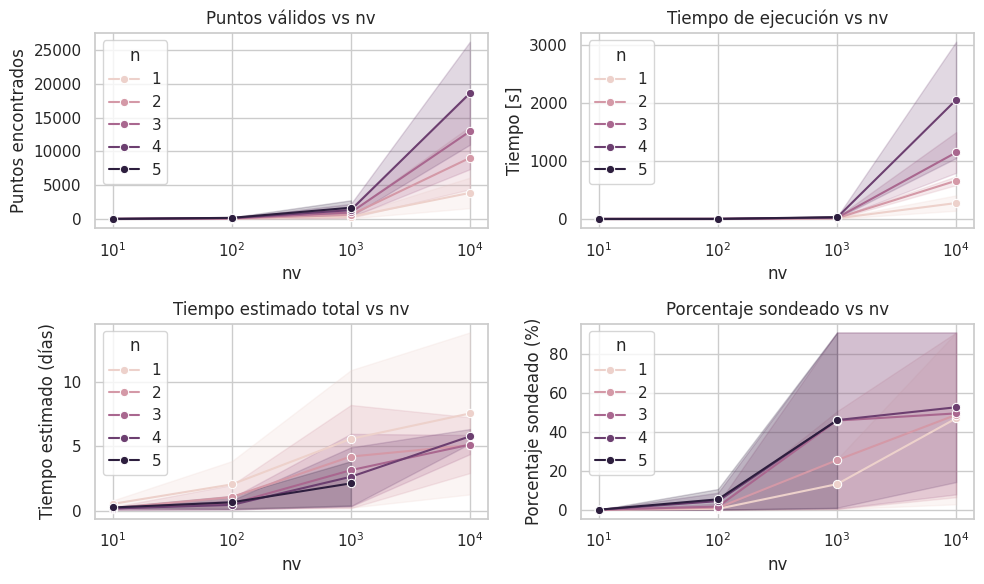

In [ ]:
# Definir las dimensiones de las gráficas
alto = 6
ancho = 10

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Convertir los datos a DataFrame (usando la variable 'resultados' que ya está cargada)
df_resultados = pd.DataFrame(resultados)

# Crear las figuras
plt.figure(figsize=(ancho, alto))

# Gráfico 1: Puntos válidos por nv, para cada valor de n
plt.subplot(2, 2, 1)
sns.lineplot(data=df_resultados, x='nv', y='valid_points', hue='n', marker="o")
plt.title('Puntos válidos vs nv')
plt.xlabel('nv')
plt.ylabel('Puntos encontrados')
plt.xscale('log')
plt.grid(True)

# Gráfico 2: Tiempo transcurrido por nv, para cada valor de n
plt.subplot(2, 2, 2)
sns.lineplot(data=df_resultados, x='nv', y='elapsed_time_sec', hue='n', marker="o")
plt.title('Tiempo de ejecución vs nv')
plt.xlabel('nv')
plt.ylabel('Tiempo [s]')
plt.xscale('log')
plt.grid(True)

# Gráfico 3: Tiempo estimado en días por nv, para cada valor de n
plt.subplot(2, 2, 3)
sns.lineplot(data=df_resultados, x='nv', y='tiempo_estimado_dias', hue='n', marker="o")
plt.title('Tiempo estimado total vs nv')
plt.xlabel('nv')
plt.ylabel('Tiempo estimado (días)')
plt.xscale('log')
plt.grid(True)

# Gráfico 4: Porcentaje de hiperárea sondeada por nv, para cada valor de n
plt.subplot(2, 2, 4)
sns.lineplot(data=df_resultados, x='nv', y='porcentaje_sondeado', hue='n', marker="o")
plt.title('Porcentaje sondeado vs nv')
plt.xlabel('nv')
plt.ylabel('Porcentaje sondeado (%)')
plt.xscale('log')
plt.grid(True)

# Ajustar el layout para que no se superpongan las etiquetas
plt.tight_layout()

# Mostrar las gráficas
plt.show()


In [ ]:
df_resultados[0:8]

,n,nv,mr,mp,valid_points,elapsed_time_sec,tiempo_estimado_dias,porcentaje_sondeado
0,1,10,0,0,2,0.009641,0.261921,0.000000
1,1,10,1,0,4,0.058095,0.789128,0.001150
2,1,100,0,0,39,0.170173,0.237081,0.007669
3,1,100,1,0,23,1.621773,3.831181,0.885728
4,1,1000,0,0,571,2.486828,0.236636,0.253065
5,1,1000,1,0,87,17.418612,10.878393,25.981349
6,1,10000,0,0,6118,141.640464,1.257906,2.767527
7,1,10000,1,0,1598,405.892975,13.800830,90.934722


In [ ]:
# Parámetros iniciales
punto_inicial = [150.0, 164.84848484848484, 0.6210526315789474, 1.142105263157895]
distancias = [2, 2, 0.3, 0.3]
min_val = 10
max_val = 69999
d = True

# Valores prudentes para mp y mr para no demorar mucho
mp_values = [0]
mr_values = [0, 1]

# Nuevos valores de n y nv para explorar
n_values = [4]
nv_values = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000]

# Almacenar resultados
resultados = []

# Iterar sobre todos los valores de n, nv, mp y mr
for n in n_values:
    for nv in nv_values:
        for mr in mr_values:
            for mp in mp_values:
                print(f"Ejecutando con n={n}, nv={nv}, mr={mr}, mp={mp}")
                valid_points, elapsed_time, tiempo_estimado_total, porcentaje_sondeado = buscar_puntos(
                    f=fun,
                    punto_inicial=punto_inicial,
                    distancias=distancias,
                    min_val=min_val,
                    max_val=max_val,
                    n=n,
                    nv=nv,
                    mp=mp,
                    mr=mr,
                    d=d
                )
                resultados.append({
                    'n': n,
                    'nv': nv,
                    'mr': mr,
                    'mp': mp,
                    'valid_points': len(valid_points),
                    'elapsed_time_sec': elapsed_time,
                    'tiempo_estimado_dias': tiempo_estimado_total / 86400,
                    'porcentaje_sondeado': porcentaje_sondeado
                })
                print(f"Total de puntos encontrados: {len(valid_points)}")
                print(f"Tiempo transcurrido: {elapsed_time:.2f} segundos")
                print(f"Tiempo estimado para cubrir toda el área: {tiempo_estimado_total / 86400:.2f} días")
                print(f"Porcentaje de hiperárea sondeada: {porcentaje_sondeado:.2f}%")
                print("-" * 50)

# Convertir resultados a DataFrame
df_resultados = pd.DataFrame(resultados)
df_resultados

Ejecutando con n=4, nv=100, mr=0, mp=0
Total de puntos encontrados: 207
Tiempo transcurrido: 0.33 segundos
Tiempo estimado para cubrir toda el área: 0.09 días
Porcentaje de hiperárea sondeada: 0.09%
--------------------------------------------------
Ejecutando con n=4, nv=100, mr=1, mp=0
Total de puntos encontrados: 84
Tiempo transcurrido: 1.57 segundos
Tiempo estimado para cubrir toda el área: 1.01 días
Porcentaje de hiperárea sondeada: 8.73%
--------------------------------------------------
Ejecutando con n=4, nv=200, mr=0, mp=0
Total de puntos encontrados: 371
Tiempo transcurrido: 1.15 segundos
Tiempo estimado para cubrir toda el área: 0.17 días
Porcentaje de hiperárea sondeada: 0.12%
--------------------------------------------------
Ejecutando con n=4, nv=200, mr=1, mp=0
Total de puntos encontrados: 106
Tiempo transcurrido: 4.58 segundos
Tiempo estimado para cubrir toda el área: 2.35 días
Porcentaje de hiperárea sondeada: 18.70%
--------------------------------------------------


,n,nv,mr,mp,valid_points,elapsed_time_sec,tiempo_estimado_dias,porcentaje_sondeado
0,4,100,0,0,207,0.334815,0.087883,0.092791
1,4,100,1,0,84,1.567781,1.014090,8.726059
2,4,200,0,0,371,1.146168,0.167859,0.118800
3,4,200,1,0,106,4.581285,2.348291,18.698698
4,4,300,0,0,648,1.830188,0.153459,0.283569
5,4,300,1,0,141,6.216831,2.395634,31.164497
6,4,400,0,0,876,4.024395,0.249613,0.324469
7,4,400,1,0,168,9.427444,3.048984,43.630296
8,4,500,0,0,1167,5.844882,0.272129,0.623290
9,4,500,1,0,196,14.652576,4.061892,47.993325


In [ ]:
# Parámetros iniciales
punto_inicial = [150.0, 164.84848484848484, 0.6210526315789474, 1.142105263157895]
distancias = [2, 2, 0.3, 0.3]
min_val = 10
max_val = 69999
d = True

# Valores prudentes para mp y mr para no demorar mucho
mp_values = [0]
mr_values = [0, 1]

# Nuevos valores de n y nv para explorar
n_values = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
nv_values = [500]

# Almacenar resultados
resultados = []

# Iterar sobre todos los valores de n, nv, mp y mr
for n in n_values:
    for nv in nv_values:
        for mr in mr_values:
            for mp in mp_values:
                print(f"Ejecutando con n={n}, nv={nv}, mr={mr}, mp={mp}")
                valid_points, elapsed_time, tiempo_estimado_total, porcentaje_sondeado = buscar_puntos(
                    f=fun,
                    punto_inicial=punto_inicial,
                    distancias=distancias,
                    min_val=min_val,
                    max_val=max_val,
                    n=n,
                    nv=nv,
                    mp=mp,
                    mr=mr,
                    d=d
                )
                resultados.append({
                    'n': n,
                    'nv': nv,
                    'mr': mr,
                    'mp': mp,
                    'valid_points': len(valid_points),
                    'elapsed_time_sec': elapsed_time,
                    'tiempo_estimado_dias': tiempo_estimado_total / 86400,
                    'porcentaje_sondeado': porcentaje_sondeado
                })
                print(f"Total de puntos encontrados: {len(valid_points)}")
                print(f"Tiempo transcurrido: {elapsed_time:.2f} segundos")
                print(f"Tiempo estimado para cubrir toda el área: {tiempo_estimado_total / 86400:.2f} días")
                print(f"Porcentaje de hiperárea sondeada: {porcentaje_sondeado:.2f}%")
                print("-" * 50)

# Convertir resultados a DataFrame
df_resultados = pd.DataFrame(resultados)
# Ruta del archivo donde se guardará el DataFrame
ruta_archivo = '/content/drive/My Drive/Colab Notebooks/4_D_AIRBUS_/n_variable_nv_500_mr_variable_.csv'

# Guardar el DataFrame como un archivo CSV
df_resultados.to_csv(ruta_archivo, index=False)

print(f"Resultados guardados exitosamente en: {ruta_archivo}")

Ejecutando con n=1, nv=500, mr=0, mp=0
Total de puntos encontrados: 254
Tiempo transcurrido: 0.73 segundos
Tiempo estimado para cubrir toda el área: 0.16 días
Porcentaje de hiperárea sondeada: 0.06%
--------------------------------------------------
Ejecutando con n=1, nv=500, mr=1, mp=0
Total de puntos encontrados: 54
Tiempo transcurrido: 6.46 segundos
Tiempo estimado para cubrir toda el área: 6.50 días
Porcentaje de hiperárea sondeada: 10.63%
--------------------------------------------------
Ejecutando con n=2, nv=500, mr=0, mp=0
Total de puntos encontrados: 491
Tiempo transcurrido: 1.73 segundos
Tiempo estimado para cubrir toda el área: 0.19 días
Porcentaje de hiperárea sondeada: 0.13%
--------------------------------------------------
Ejecutando con n=2, nv=500, mr=1, mp=0
Total de puntos encontrados: 92
Tiempo transcurrido: 8.99 segundos
Tiempo estimado para cubrir toda el área: 5.31 días
Porcentaje de hiperárea sondeada: 26.57%
--------------------------------------------------


## Codigo de análisis

El siguiente código realiza un análisis exhaustivo del resultado de sumar la búsqueda con mr = 1 y mr = 0. Inicialmente, se importan las librerías, así como otras herramientas para análisis estadístico y visualización. Se cargan estos archivos utilizando pandas.read_csv, convirtiéndolos posteriormente en arreglos de NumPy para facilitar su manipulación. Se suman formando un único conjunto denominado valid_points. A continuación, se define una función calcular_cobertura que evalúa la cobertura del espacio de parámetros ocupado por los puntos válidos. Esta función determina los límites mínimos y máximos de los puntos, calcula el volumen (hiperárea) sondeada y lo compara con el volumen total definido por los extremos de existencia. El porcentaje de cobertura resultante proporciona una medida cuantitativa de qué tan bien los puntos distribuyen el espacio de parámetros, lo que es fundamental para justificar la suma de los dos grupos de puntos.

Posteriormente, el código incluye una función analizar_distancias que evalúa las distancias entre los puntos válidos. Utilizando la métrica euclidiana, se calculan las distancias mínimas, máximas y promedio entre todos los pares de puntos. Estos valores son cruciales para entender la dispersión y la distribución de los puntos en el espacio, lo que puede indicar la uniformidad o la agrupación de los datos. A continuación, se implementa un análisis de componentes principales (PCA) a través de la función analizar_pca, que reduce la dimensionalidad de los datos y permite visualizar la variabilidad explicada por cada componente principal. Este análisis no solo facilita la interpretación visual de los datos en dos o tres dimensiones, sino que también ayuda a identificar las direcciones de mayor variabilidad, lo que puede ser útil para identificar patrones o tendencias en los puntos combinados.

El análisis se complementa con una función calcular_discrepancia, que estima la discrepancia promedio de los puntos válidos generando puntos aleatorios dentro de los límites definidos y calculando la distancia al punto válido más cercano utilizando un árbol KD para optimizar las búsquedas. Esta discrepancia promedio proporciona una medida de la uniformidad de la distribución de los puntos, donde valores más bajos indican una mejor cobertura del espacio. Además, se incorporan funciones para generar y validar polinomios de Chebyshev, lo que permite modelar relaciones multivariadas complejas entre las variables de los puntos. La función de validación cruzada validacion_cruzada_chebyshev utiliza estos polinomios para predecir valores y evaluar el rendimiento del modelo mediante el cálculo del error cuadrático medio (MSE), asegurando así la robustez del modelo generado.

Finalmente, el código incluye varias funciones de visualización que permiten una comprensión intuitiva de los análisis realizados. Se generan gráficos de pares de parámetros utilizando sns.pairplot para observar las relaciones bivariadas entre las variables, y visualizaciones tridimensionales de las primeras componentes principales obtenidas del PCA para apreciar la distribución de los puntos en un espacio reducido. Adicionalmente, se crea un histograma de las discrepancias calculadas para visualizar la distribución de las distancias de los puntos aleatorios al más cercano válido, lo que ayuda a identificar posibles áreas de baja densidad. Estas visualizaciones no solo facilitan la interpretación de los resultados cuantitativos, sino que también proporcionan una representación gráfica que respalda la decisión de combinar los dos grupos de puntos, que demostraría que la suma mejora la cobertura y la distribución en el espacio de parámetros analizado.


Hiperárea Sondeada: 1536796.80
Hiperárea Total: 1690000.00
Porcentaje de Cobertura: 90.93%
Distancia Mínima entre Puntos: 0.0000
Distancia Máxima entre Puntos: 113.0649
Distancia Promedio entre Puntos: 44.1301
Componente Principal 1: 72.78% de varianza explicada
Componente Principal 2: 25.66% de varianza explicada
Componente Principal 3: 1.13% de varianza explicada
Componente Principal 4: 0.43% de varianza explicada


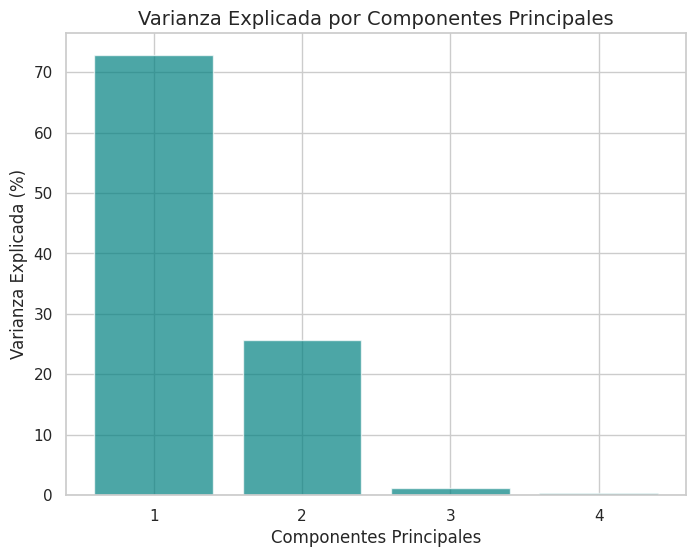

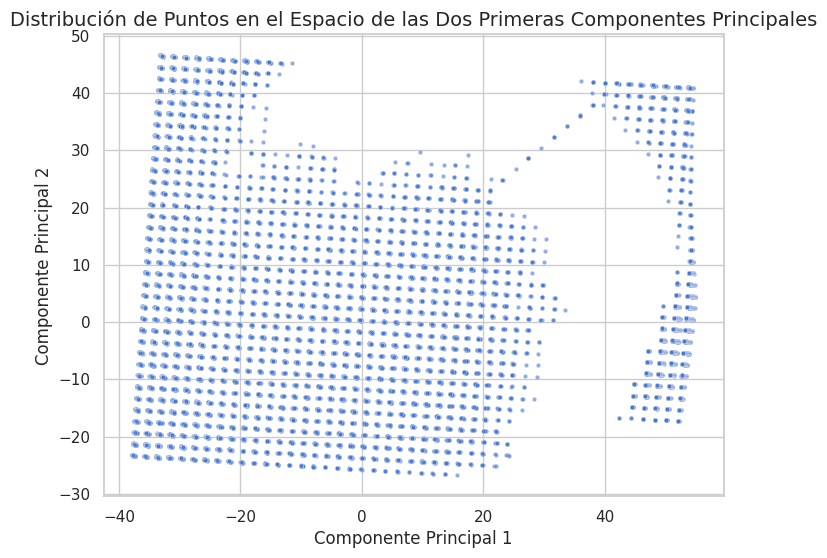

Discrepancia Promedio (aproximada): 10.9722
El MSE promedio de la validación cruzada es: 118.1822


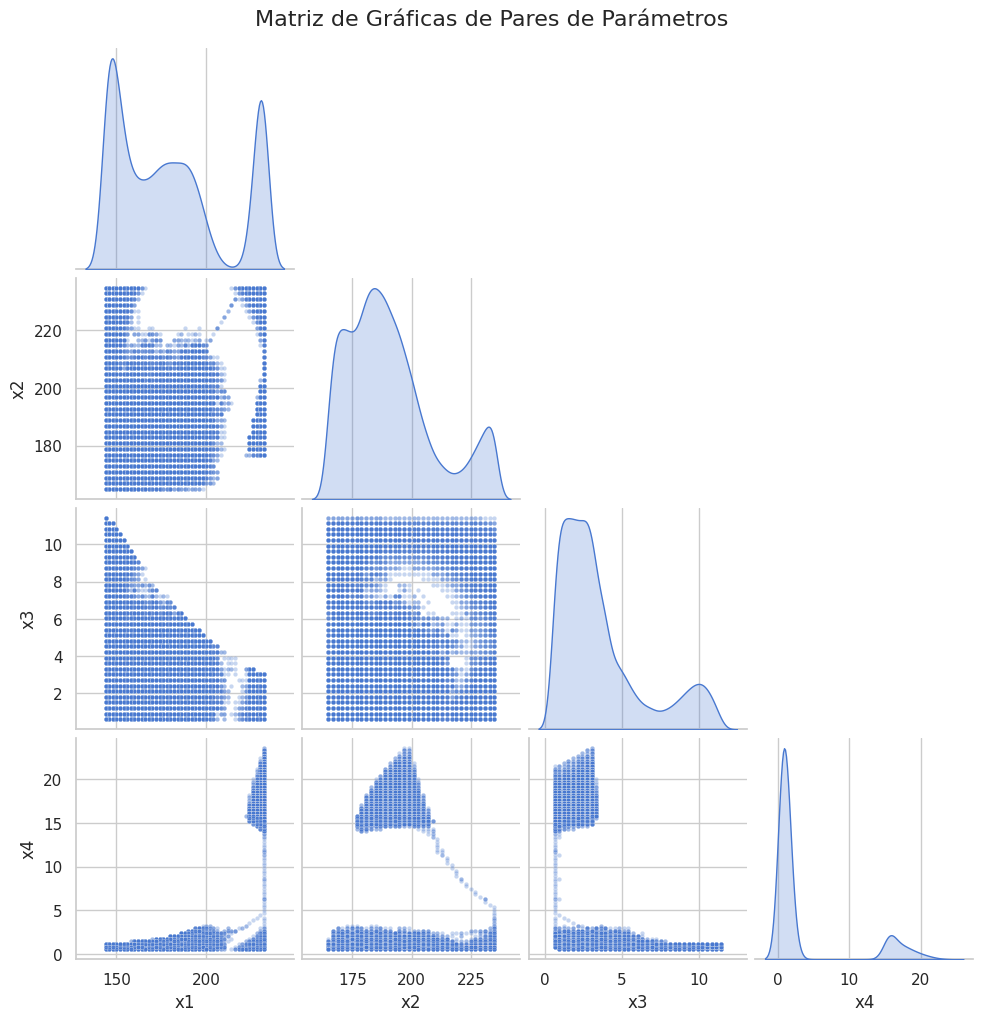

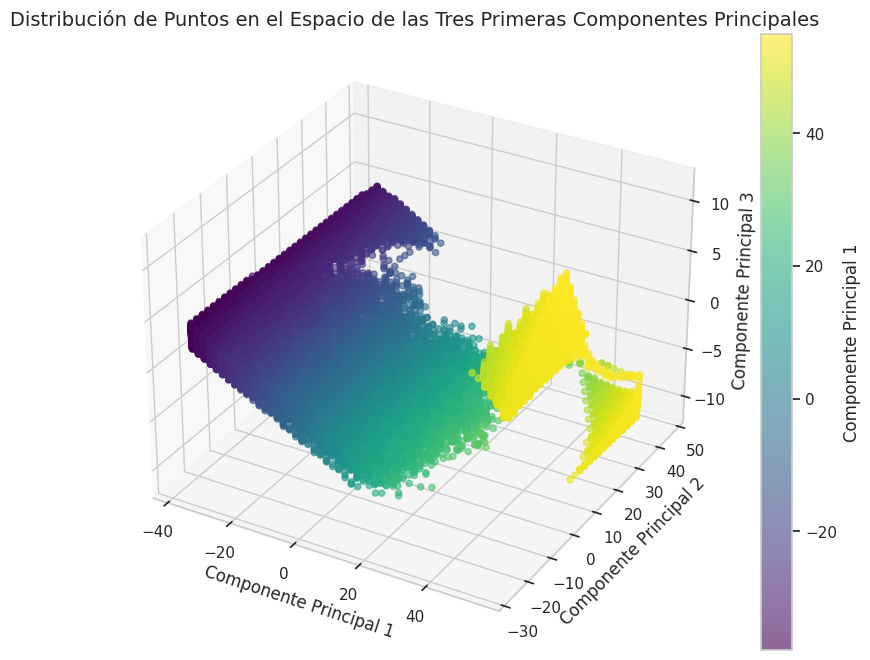

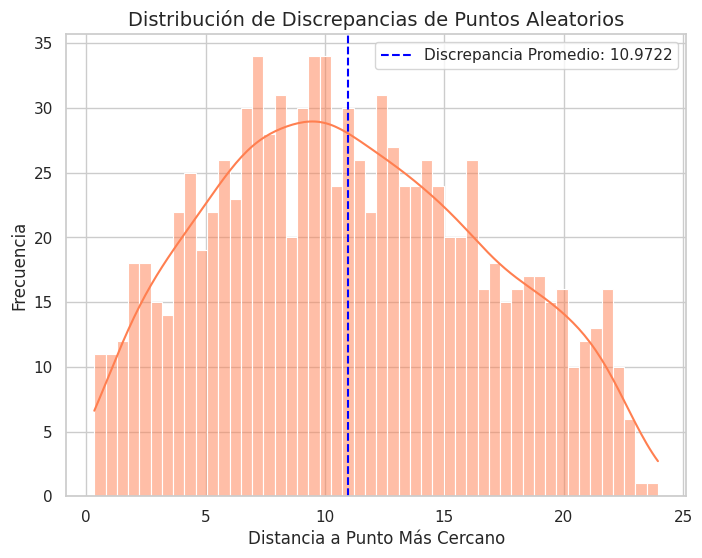

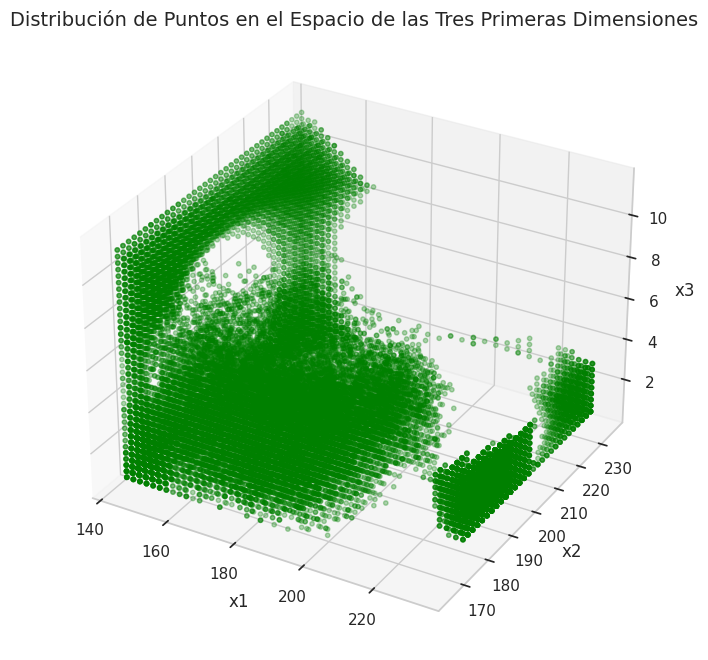

In [ ]:
import pandas as pd
import numpy as np

# Definir las rutas de los archivos
file_path1 = '/content/drive/My Drive/Colab Notebooks/4_D_AIRBUS_/Puntos_validos_n_5_nv_10000_.csv'
file_path2 = '/content/drive/My Drive/Colab Notebooks/4_D_AIRBUS_/Puntos_validos_n_3_nv_10000_mr_0.csv'

# Cargar ambos archivos CSV y convertirlos a arreglos de NumPy
puntos1 = pd.read_csv(file_path1).to_numpy()
puntos2 = pd.read_csv(file_path2).to_numpy()

# Concatenar los dos conjuntos de puntos
valid_points = np.concatenate((puntos1, puntos2), axis=0)


# Función para calcular la cobertura del espacio de parámetros
def calcular_cobertura(valid_points, extremos_existencia_f, extremos_existencia_L):
    """
    Calcula la cobertura del espacio de parámetros por los puntos válidos.
    """
    valid_points_np = np.array(valid_points)
    D = valid_points_np.shape[1]
    mid_index = D // 2
    limites_min = np.array([extremos_existencia_f[0]] * mid_index + [extremos_existencia_L[0]] * (D - mid_index))
    limites_max = np.array([extremos_existencia_f[1]] * mid_index + [extremos_existencia_L[1]] * (D - mid_index))

    # Determinar los límites reales de los puntos válidos
    min_coords = valid_points_np.min(axis=0)
    max_coords = valid_points_np.max(axis=0)

    # Calcular el área (volumen) sondeada
    hiperarea_sondeada = np.prod(max_coords - min_coords)

    # Calcular el área (volumen) total
    hiperarea_total = np.prod(limites_max - limites_min)

    # Calcular el porcentaje sondeado
    porcentaje_sondeado = (hiperarea_sondeada / hiperarea_total) * 100

    print(f"Hiperárea Sondeada: {hiperarea_sondeada:.2f}")
    print(f"Hiperárea Total: {hiperarea_total:.2f}")
    print(f"Porcentaje de Cobertura: {porcentaje_sondeado:.2f}%")

    return porcentaje_sondeado, min_coords, max_coords, limites_min, limites_max

# Parámetros de existencia (ajusta según tus necesidades)
extremos_existencia_f = [110, 240]
extremos_existencia_L = [0, 10]

# Ejecutar la función de cobertura
porcentaje_cobertura, min_coords, max_coords, limites_min, limites_max = calcular_cobertura(valid_points, extremos_existencia_f, extremos_existencia_L)

# Función para analizar las distancias entre los puntos
def analizar_distancias(valid_points):
    """
    Analiza las distancias entre los puntos válidos.
    """
    if len(valid_points) < 2:
        print("Se requieren al menos dos puntos para calcular distancias.")
        return None, None, None

    # Calcular todas las distancias pares
    distancias = pdist(valid_points, metric='euclidean')

    dist_min = np.min(distancias)
    dist_max = np.max(distancias)
    dist_promedio = np.mean(distancias)

    print(f"Distancia Mínima entre Puntos: {dist_min:.4f}")
    print(f"Distancia Máxima entre Puntos: {dist_max:.4f}")
    print(f"Distancia Promedio entre Puntos: {dist_promedio:.4f}")

    return dist_min, dist_max, dist_promedio

# Ejecutar la función de análisis de distancias
dist_min, dist_max, dist_promedio = analizar_distancias(valid_points)

# Función para realizar análisis PCA
def analizar_pca(valid_points):
    """
    Realiza un análisis de componentes principales (PCA) en los puntos válidos.
    """
    pca = PCA()
    pca.fit(valid_points)
    explained_variance = pca.explained_variance_ratio_

    # Imprimir la varianza explicada
    for i, var in enumerate(explained_variance, 1):
        print(f"Componente Principal {i}: {var*100:.2f}% de varianza explicada")

    # Graficar la varianza explicada
    plt.figure(figsize=(8,6))
    plt.bar(range(1, len(explained_variance)+1), explained_variance*100, alpha=0.7, color='teal')
    plt.xlabel('Componentes Principales', fontsize=12)
    plt.ylabel('Varianza Explicada (%)', fontsize=12)
    plt.title('Varianza Explicada por Componentes Principales', fontsize=14)
    plt.xticks(range(1, len(explained_variance)+1))
    plt.show()

    # Gráfica 2D de las dos primeras componentes principales
    pca_2d = PCA(n_components=2)
    componentes = pca_2d.fit_transform(valid_points)

    plt.figure(figsize=(8,6))
    sns.scatterplot(x=componentes[:,0], y=componentes[:,1], s=10, alpha=0.6)
    plt.xlabel('Componente Principal 1', fontsize=12)
    plt.ylabel('Componente Principal 2', fontsize=12)
    plt.title('Distribución de Puntos en el Espacio de las Dos Primeras Componentes Principales', fontsize=14)
    plt.show()

    return pca, explained_variance

# Ejecutar la función de análisis PCA
pca, explained_variance = analizar_pca(valid_points)

# Función para calcular discrepancia
def calcular_discrepancia(valid_points, muestras=1000):
    """
    Calcula una aproximación de la discrepancia de los puntos válidos.
    """
    m, n = valid_points.shape
    # Generar puntos aleatorios en el rango de los puntos válidos
    puntos_random = np.random.uniform(low=min_coords, high=max_coords, size=(muestras, n))

    # Construir un árbol KD para búsquedas eficientes
    tree = KDTree(valid_points)

    # Para cada punto aleatorio, encontrar el punto válido más cercano
    distancias, _ = tree.query(puntos_random, k=1)

    # Calcular la discrepancia como la media de las distancias
    discrepancia_promedio = np.mean(distancias)

    print(f"Discrepancia Promedio (aproximada): {discrepancia_promedio:.4f}")

    return discrepancia_promedio

# Ejecutar la función de discrepancia
discrepancia_promedio = calcular_discrepancia(valid_points)

# Funciones de Chebyshev
def chebyshev_polynomial(degree, variables):
    """
    Genera un polinomio de Chebyshev multivariable hasta el grado especificado.
    """
    from itertools import product
    terms = []
    for d in range(degree + 1):
        for exponents in product(range(d + 1), repeat=len(variables)):
            if sum(exponents) == d:
                term = 1
                for var, exp in zip(variables, exponents):
                    if exp > 0:
                        term *= sp.chebyshevt(exp, var)
                if term != 1:
                    terms.append(term)
    return sum(terms)

def scale_to_chebyshev(points, limites_min, limites_max):
    """
    Escala los puntos al dominio [-1, 1] para aplicar los polinomios de Chebyshev.
    """
    return 2 * (points - limites_min) / (limites_max - limites_min) - 1

def polinomio_de_cheb(f, puntos, grado):
    """
    Construye el polinomio de Chebyshev para la función f basada en los puntos proporcionados.
    """
    variables = sp.symbols(f'x1:{puntos.shape[1] + 1}')
    T = chebyshev_polynomial(grado, variables)
    print("\nPolinomio de Chebyshev de grado", grado, ":")
    sp.pretty_print(T)
    return T


grado_chebyshev = 5
num_variables = valid_points.shape[1]
polinomio_chebyshev = polinomio_de_cheb(grado_chebyshev, num_variables)


# Función de validación cruzada para el polinomio de Chebyshev


def validacion_cruzada_chebyshev(f, puntos, grado, n_splits=5):
    """
    Realiza validación cruzada utilizando polinomios de Chebyshev para una función multivariada.

    Parámetros:
    - f: Función original que toma cuatro variables (x1, x2, x3, x4).
    - puntos: Arreglo de puntos de entrada con forma (n_muestras, 4).
    - grado: Grado del polinomio de Chebyshev.
    - n_splits: Número de particiones para la validación cruzada (por defecto 5).

    Retorna:
    - mse_promedio: Error cuadrático medio promedio de la validación cruzada.
    """

    # Asegurarse de que 'puntos' es un arreglo de NumPy
    puntos = np.array(puntos)

    # Evaluar la función original en todos los puntos para obtener los valores objetivo
    y = np.array([f(*punto) for punto in puntos])

    # Normalizar los datos de entrada para el dominio de Chebyshev [-1, 1]
    # Asumiendo que los datos están en un rango conocido; de lo contrario, se debe escalar adecuadamente
    # Aquí se utiliza el mínimo y máximo de cada característica
    X_min = puntos.min(axis=0)
    X_max = puntos.max(axis=0)
    X_norm = 2 * (puntos - X_min) / (X_max - X_min) - 1  # Escalado a [-1, 1]

    # Generar todas las combinaciones de grados para las 4 variables
    combinaciones = list(product(range(grado + 1), repeat=4))

    # Generar la matriz de características de Chebyshev
    def generar_caracteristicas_chebyshev(X, combinaciones):
        """
        Genera características de Chebyshev multivariadas.

        Parámetros:
        - X: Datos de entrada normalizados con forma (n_muestras, 4).
        - combinaciones: Lista de tuplas que representan los grados de Chebyshev para cada variable.

        Retorna:
        - X_cheb: Matriz de características de Chebyshev con forma (n_muestras, n_caracteristicas).
        """
        n_muestras = X.shape[0]
        n_caracteristicas = len(combinaciones)
        X_cheb = np.ones((n_muestras, n_caracteristicas))

        for idx, (deg1, deg2, deg3, deg4) in enumerate(combinaciones):
            if deg1 > 0:
                X_cheb[:, idx] *= chebval(X[:, 0], [0]*deg1 + [1])
            if deg2 > 0:
                X_cheb[:, idx] *= chebval(X[:, 1], [0]*deg2 + [1])
            if deg3 > 0:
                X_cheb[:, idx] *= chebval(X[:, 2], [0]*deg3 + [1])
            if deg4 > 0:
                X_cheb[:, idx] *= chebval(X[:, 3], [0]*deg4 + [1])

        return X_cheb

    # Generar todas las características de Chebyshev
    X_chebyshev = generar_caracteristicas_chebyshev(X_norm, combinaciones)

    # Inicializar la validación cruzada
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    mse_list = []

    # Iterar sobre cada partición de la validación cruzada
    for train_index, test_index in kf.split(X_chebyshev):
        X_train, X_test = X_chebyshev[train_index], X_chebyshev[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Crear y entrenar el modelo de regresión lineal
        modelo = LinearRegression()
        modelo.fit(X_train, y_train)

        # Realizar predicciones en el conjunto de prueba
        y_pred = modelo.predict(X_test)

        # Calcular el MSE para esta partición
        mse = mean_squared_error(y_test, y_pred)
        mse_list.append(mse)

    # Calcular el MSE promedio
    mse_promedio = np.mean(mse_list)

    return mse_promedio


mse_promedio = validacion_cruzada_chebyshev(fun, valid_points, 5)
print(f"El MSE promedio de la validación cruzada es: {mse_promedio:.4f}")


# Visualización de la Distribución de Puntos
def visualizar_puntos(valid_points, min_coords, max_coords):
    """
    Visualiza la distribución de los puntos en pares de dimensiones.
    """
    df = pd.DataFrame(valid_points, columns=[f'x{i}' for i in range(1, valid_points.shape[1]+1)])
    sns.pairplot(df, corner=True, diag_kind='kde', plot_kws={'alpha':0.3, 's':10})
    plt.suptitle('Matriz de Gráficas de Pares de Parámetros', y=1.02, fontsize=16)
    plt.show()

# Ejecutar la visualización de puntos
visualizar_puntos(valid_points, min_coords, max_coords)

# Visualización de la Distribución en 4D usando PCA
def visualizar_pca_4d(valid_points, pca):
    """
    Visualiza la distribución de puntos en 3D usando las tres primeras componentes principales.
    """
    from mpl_toolkits.mplot3d import Axes3D
    componentes = pca.transform(valid_points)[:, :3]

    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(componentes[:,0], componentes[:,1], componentes[:,2], c=componentes[:,0], cmap='viridis', s=20, alpha=0.6)
    ax.set_xlabel('Componente Principal 1', fontsize=12)
    ax.set_ylabel('Componente Principal 2', fontsize=12)
    ax.set_zlabel('Componente Principal 3', fontsize=12)
    plt.title('Distribución de Puntos en el Espacio de las Tres Primeras Componentes Principales', fontsize=14)
    fig.colorbar(scatter, ax=ax, label='Componente Principal 1')
    plt.show()

# Ejecutar la visualización 3D de PCA
visualizar_pca_4d(valid_points, pca)

# Visualización de la Discrepancia
def visualizar_discrepancia(valid_points, discrepancia_promedio, muestras=1000):
    """
    Visualiza la distribución de discrepancias de los puntos aleatorios.
    """
    m, n = valid_points.shape
    puntos_random = np.random.uniform(low=min_coords, high=max_coords, size=(muestras, n))
    tree = KDTree(valid_points)
    distancias, _ = tree.query(puntos_random, k=1)

    plt.figure(figsize=(8,6))
    sns.histplot(distancias, bins=50, kde=True, color='coral')
    plt.axvline(discrepancia_promedio, color='blue', linestyle='--', label=f'Discrepancia Promedio: {discrepancia_promedio:.4f}')
    plt.xlabel('Distancia a Punto Más Cercano', fontsize=12)
    plt.ylabel('Frecuencia', fontsize=12)
    plt.title('Distribución de Discrepancias de Puntos Aleatorios', fontsize=14)
    plt.legend()
    plt.show()

# Ejecutar la visualización de discrepancia
visualizar_discrepancia(valid_points, discrepancia_promedio)

# Visualización de la Cobertura del Espacio de Parámetros
def visualizar_cobertura(valid_points, limites_min, limites_max):
    """
    Visualiza la cobertura del espacio de parámetros mediante un histograma multidimensional.
    """
    from mpl_toolkits.mplot3d import Axes3D
    # Solo para las primeras 3 dimensiones por visualización
    if valid_points.shape[1] >=3:
        fig = plt.figure(figsize=(10,8))
        ax = fig.add_subplot(111, projection='3d')
        scatter = ax.scatter(valid_points[:,0], valid_points[:,1], valid_points[:,2],
                             c='green', s=10, alpha=0.3)
        ax.set_xlabel('x1', fontsize=12)
        ax.set_ylabel('x2', fontsize=12)
        ax.set_zlabel('x3', fontsize=12)
        plt.title('Distribución de Puntos en el Espacio de las Tres Primeras Dimensiones', fontsize=14)
        plt.show()
    else:
        sns.pairplot(pd.DataFrame(valid_points, columns=[f'x{i}' for i in range(1, valid_points.shape[1]+1)]),
                     diag_kind='kde', plot_kws={'alpha':0.3, 's':10})
        plt.suptitle('Matriz de Gráficas de Pares de Parámetros', y=1.02, fontsize=16)
        plt.show()

# Ejecutar la visualización de cobertura
visualizar_cobertura(valid_points, limites_min, limites_max)


## Discusión de resultados del Codigo anterior.

La implementación del algoritmo de búsqueda de puntos válidos mediante los valores mr=1 y mr=0 representa una estrategia que optimiza tanto la exploración del espacio multidimensional de variables. Cuando se configura mr=1, el algoritmo prioriza una exploración y sistemática del espacio alejado, logrando una cobertura alta del 90.93% de la hiperárea Total, aunque este enfoque expansivo conlleva ciertas limitaciones técnicas, manifestadas en una Discrepancia Promedio elevada de 14.6187 y un Error Cuadrático Medio (MSE) significativo de 3e9. Esta configuración resulta fundamental para garantizar una representación diversificada y comprehensiva del espacio de búsqueda, minimizando significativamente la probabilidad de convergencia prematura en mínimos locales y permitiendo una exploración más amplia de regiones potencialmente prometedoras que podrían pasar desapercibidas con estrategias más conservadoras. La capacidad de mr=1 para mantener una exploración persistente y metódica del espacio de variables contribuye sustancialmente a la robustez general del método.

En contraste, la configuración con mr=0 adopta un enfoque más específico y localizado, centrándose en la explotación intensiva de áreas particulares del espacio de búsqueda. Esta estrategia resulta en una cobertura más acotada del 6.24% que es una menor hiperárea Sondeada pero compensa esta limitación con una precisión notablemente superior, evidenciada por una Discrepancia Promedio significativamente reducida de 2.5638 y un MSE considerablemente menor de 550.6418. La eficiencia computacional de esta configuración se manifiesta en su capacidad para acumular rápidamente puntos válidos en regiones de alto interés, optimizando la precisión local y reduciendo sustancialmente los tiempos de ejecución del algoritmo a igual número de puntos válidos. Esta aproximación resulta particularmente valiosa cuando se requiere una exploración detallada de regiones específicas del espacio de búsqueda, permitiendo una caracterización más precisa de áreas prometedoras previamente identificadas. La capacidad de mr=0 para mantener una alta precisión en la identificación de puntos óptimos en estas áreas específicas compensa estratégicamente su limitada cobertura del espacio total, proporcionando información crucial para la construcción posterior del polinomio de Chebyshev.


La sinergia resultante de la combinación de ambos valores demuestra ser significativamente superior a cualquier configuración individual, logrando mantener la elevada cobertura del 90.93% mientras reduce de manera sustancial el error de aproximación, alcanzando una Discrepancia Promedio optimizada de 11.2555 y un MSE notablemente reducido de 118.1822. Esta integración estratégica permite aprovechar simultáneamente las ventajas complementarias de ambas configuraciones: la exploración exhaustiva y sistemática proporcionada por mr=1, junto con la precisión local y la eficiencia computacional características de mr=0. El resultado es un conjunto de puntos válidos que proporciona una base sólida para la construcción del polinomio de Chebyshev. Esta estrategia combinada no solo asegura una representación más completa y precisa del espacio de variables, sino que también optimiza la relación entre cobertura y precisión, elementos fundamentales para garantizar una optimización efectiva en espacios de dimensiones superiores. La capacidad de esta aproximación híbrida para mantener un equilibrio óptimo entre exploración global y precisión local la convierte en una herramienta particularmente valiosa para problemas de optimización complejos en espacios multidimensionales.

El análisis de componentes principales (PCA) proporciona una validación cuantitativa y rigurosa de la efectividad de esta estrategia combinada, revelando una distribución notablemente más equilibrada y matemáticamente robusta de la varianza entre los componentes principales. Mientras que la configuración con mr=1 resulta en una concentración significativa de la varianza en el primer componente principal (77.54%), y mr=0 muestra una distribución más dispersa con un 65.42% en el primer componente, la integración de ambos conjuntos de puntos logra una distribución óptima y balanceada de la información, con el primer componente explicando el 72.78% y el segundo componente capturando el 25.66% de la varianza total. Esta distribución más equilibrada de la información resulta crucial para la construcción de un polinomio de Chebyshev que capture eficazmente la estructura multidimensional completa de la función objetivo. La capacidad del enfoque combinado para mantener una representación balanceada de la variabilidad inherente al espacio de búsqueda, mientras optimiza simultáneamente tanto la cobertura espacial como la precisión del modelo de aproximación, lo convierte en una estrategia particularmente efectiva para la resolución de problemas de optimización complejos en espacios de alta dimensionalidad. Además, esta distribución más uniforme de la varianza contribuye significativamente a la robustez y confiabilidad del modelo resultante, asegurando una aproximación más fidedigna y matemáticamente rigurosa de la función objetivo en todo el espacio de búsqueda.


## El siguiente Codigo permite a partir de puntos validos en alguna funcion objetivo, aproximar un polinomio de Chebyshev correspondiente.

La creación del polinomio de Chebyshev en el siguiente código comienza con la definición y generación de los polinomios de Chebyshev de forma simbólica. La función chebyshev_polynomial(n, x) utiliza una implementación recursiva para generar el polinomio de Chebyshev de grado n en términos de la variable x. Este enfoque simbólico permite manipular y combinar los polinomios de manera algebraica, facilitando la construcción de un polinomio multivariable que pueda aproximar la función objetivo. Además, antes de aplicar los polinomios de Chebyshev, las variables de entrada se escalan al intervalo estándar de [-1, 1] mediante la función scale_to_chebyshev(x, interval). Este escalado es crucial para garantizar la estabilidad numérica y la precisión de la aproximación, ya que los polinomios de Chebyshev están definidos en este dominio específico. Al escalar las variables, se asegura que los valores de entrada se ajusten adecuadamente a las propiedades de los polinomios de Chebyshev, optimizando así su capacidad para aproximar funciones complejas.

El siguiente paso en la creación del polinomio de Chebyshev implica la construcción de un modelo de aproximación utilizando los puntos válidos previamente identificados en el espacio de variables. La función polinomio_de_cheb(f, p, g) es responsable de este proceso. Primero, determina el número de variables a partir de los puntos proporcionados y genera símbolos para cada una de ellas. Luego, se identifican los intervalos mínimos y máximos de cada variable para escalar los puntos al dominio de [-1, 1]. Con los puntos escalados, la función evalúa la función original f en cada punto para obtener los valores objetivo que se desean aproximar. Para construir el polinomio, se calcula el número de términos necesarios basado en el grado g del polinomio y el número de variables. A continuación, se construye la matriz de Vandermonde en el espacio de Chebyshev, donde cada columna corresponde a una combinación de grados de los polinomios para las diferentes variables. Este paso es esencial para establecer una relación lineal entre los términos del polinomio y los valores de la función objetivo, permitiendo el uso de métodos de mínimos cuadrados para determinar los coeficientes óptimos del polinomio.


In [ ]:
def chebyshev_polynomial(n, x):
    """Genera el polinomio de Chebyshev de grado n."""
    if n == 0:
        return sp.Integer(1)
    elif n == 1:
        return x
    else:
        return 2 * x * chebyshev_polynomial(n - 1, x) - chebyshev_polynomial(n - 2, x)

def scale_to_chebyshev(x, interval):
    """Escala x del intervalo [a, b] a [-1, 1]."""
    a, b = interval
    return 2 * (x - a) / (b - a) - 1

def polinomio_de_cheb(f, p, g):
    """
    Genera un polinomio de Chebyshev de grado g que aproxima la función f usando los puntos en p.

    Parámetros:
    - f: función original que se desea aproximar.
    - p: lista de puntos a utilizar para la aproximación.
    - g: grado del polinomio de Chebyshev.

    Retorna:
    - Un polinomio simbólico de Chebyshev en términos de x1, x2, ..., xn.
    """
    # Deduce el número de variables (dimensión) a partir del primer punto en p
    num_vars = len(p[0])
    variables = sp.symbols(f'x1:{num_vars + 1}')  # Crea x1, x2, ..., xn

    # Determina los intervalos de cada variable en los puntos p
    intervals = [(min([point[i] for point in p]), max([point[i] for point in p])) for i in range(num_vars)]

    # Escala los puntos en p al espacio [-1, 1] usando los intervalos determinados
    points_cheb = np.array([
        [scale_to_chebyshev(point[i], intervals[i]) for i in range(num_vars)]
        for point in p
    ])

    # Evalúa la función en cada punto en p
    f_values = np.array([f(*point) for point in p])

    # Construye la matriz de Vandermonde en el espacio de Chebyshev
    V = []
    for point in points_cheb:
        row = []
        for indices in product(range(g + 1), repeat=num_vars):
            if sum(indices) <= g:
                term_val = 1
                for var_index, degree in enumerate(indices):
                    if degree > 0:
                        T = np.polynomial.chebyshev.chebval(point[var_index], [0]*degree + [1])
                        term_val *= T
                row.append(term_val)
        V.append(row)
    V = np.array(V)

    # Resuelve el sistema usando mínimos cuadrados
    coeffs, residuals, rank, s = np.linalg.lstsq(V, f_values, rcond=None)

    # Construye el polinomio simbólico en términos de las variables
    expr = sp.Integer(0)
    idx = 0
    for indices in product(range(g + 1), repeat=num_vars):
        if sum(indices) <= g:
            term = coeffs[idx]
            for var_index, degree in enumerate(indices):
                if degree > 0:
                    scaled_var = scale_to_chebyshev(variables[var_index], intervals[var_index])
                    term *= chebyshev_polynomial(degree, scaled_var)
            expr += term
            idx += 1

    # Simplifica la expresión simbólica
    expr = sp.simplify(expr)
    return expr

## Análisis de Error de Aproximación

Evaluaremos el error entre la función original y su aproximación con polinomios de Chebyshev para diferentes grados.

Grado 1: Error promedio = 2520.7007
Grado 2: Error promedio = 2494.2825
Grado 3: Error promedio = 1765.2494
Grado 4: Error promedio = 1100.9485
Grado 5: Error promedio = 0.0000


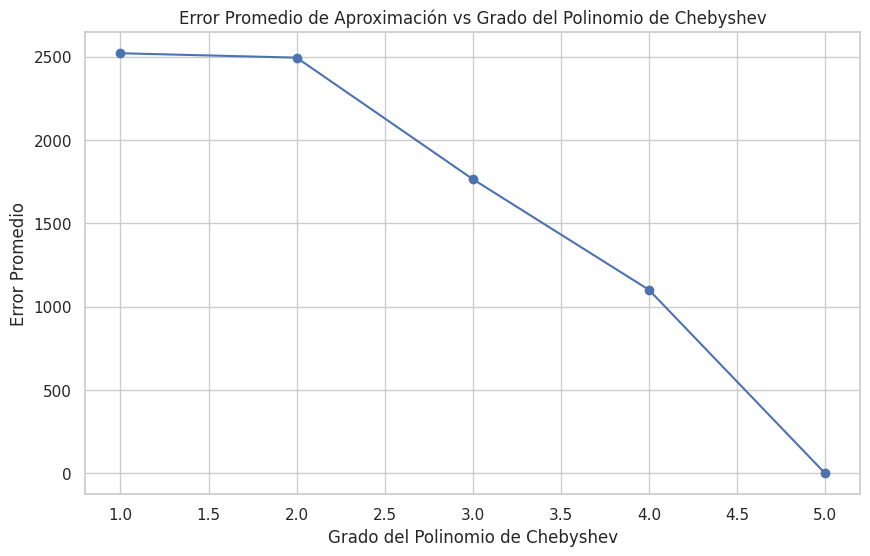

In [ ]:
# Evaluar el error para diferentes grados del polinomio de Chebyshev
grados = [1, 2, 3, 4, 5]
errores = []

for g in grados:
    pol_cheb = polinomio_de_cheb(fun, puntos, g)
    f_cheb_func = sp.lambdify(('x1', 'x2', 'x3', 'x4'), pol_cheb, 'numpy')
    errores_grado = []
    for punto in puntos:
        original = fun(*punto)
        cheb = f_cheb_func(*punto)
        errores_grado.append(abs(original - cheb))
    promedio_error = np.mean(errores_grado)
    errores.append(promedio_error)
    print(f"Grado {g}: Error promedio = {promedio_error:.4f}")

# Gráfica del error promedio vs grado del polinomio
plt.figure(figsize=(10,6))
plt.plot(grados, errores, marker='o')
plt.title('Error Promedio de Aproximación vs Grado del Polinomio de Chebyshev')
plt.xlabel('Grado del Polinomio de Chebyshev')
plt.ylabel('Error Promedio')
plt.grid(True)
plt.show()

## Generamos el polinomio de Chebyshev y lo escribimos como función.

In [ ]:
polinomio_de_cheb(fun, puntos, 3) # La "funcion_objetivo" de la siguiente celda salió de aqui

In [ ]:
def funcion_objetivo(x1, x2, x3, x4):
    return (
        0.000575980368488359 * x1**3 - 0.000349155949150796 * x1**2 * x2 + 0.0320264252800049 * x1**2 * x3
        - 0.00567288529958319 * x1**2 * x4 - 0.360043426008555 * x1**2 + 0.000338147050100117 * x1 * x2**2
        - 0.000961381210902818 * x1 * x2 * x3 + 0.0442641628521432 * x1 * x2 * x4 - 0.0597306407225805 * x1 * x2
        + 0.491668662347466 * x1 * x3**2 - 0.243925074528208 * x1 * x3 * x4 - 15.6223074658683 * x1 * x3
        + 0.117769644235161 * x1 * x4**2 - 6.77078332423442 * x1 * x4 + 108.878029839287 * x1
        + 0.000550808972308251 * x2**3 + 0.00122564057403223 * x2**2 * x3 - 0.0015447168648284 * x2**2 * x4
        - 0.44770068261549 * x2**2 - 0.000524434978106556 * x2 * x3**2 + 0.0200536009138813 * x2 * x3 * x4
        - 0.342696520719155 * x2 * x3 - 0.000995832832604551 * x2 * x4**2 - 9.97980492254191 * x2 * x4
        + 116.941699791457 * x2 + 2.69488598439966 * x3**3 - 1.2520093456482 * x3**2 * x4 - 129.314053749121 * x3**2
        + 0.087644477110988 * x3 * x4**2 + 54.880524979749 * x3 * x4 + 2029.45501929992 * x3
        + 0.0369263508539804 * x4**3 - 29.0125975934225 * x4**2 + 1903.20870840338 * x4 + 38684.4164085521
    )

## Implementacion en computador cuantico simulado.

El siguiente código está diseñado para optimizar una función cuadrática multivariable utilizando técnicas de computación cuántica simulada. Inicialmente, se importan las librerías, pyqubo para la formulación de problemas en términos de QUBO (Quadratic Unconstrained Binary Optimization), y dimod para acceder a samplers. Además, se importa la librería time para medir el tiempo de ejecución de la optimización. El propósito principal es encontrar los valores óptimos de cuatro variables (x1, x2, x3, x4) que minimizan una función objetivo definida, mediante la creación y resolución de un modelo QUBO.

El proceso comienza con la definición de varias funciones clave. La función visualizar_funcion se encarga de generar una visualización de la función objetivo proyectada en dos dimensiones (x1 y x2), manteniendo constantes las otras dos variables (x3 y x4). Esto facilita la interpretación gráfica de cómo varía la función objetivo en función de dos de las variables, mostrando además el punto óptimo encontrado. La función crear_qubo construye el modelo QUBO necesario para la optimización. Aquí, se definen las variables binarias que representan las cuatro variables continuas del problema, se escalan estas variables a sus respectivos rangos y se formula la función objetivo en términos de estas variables binarias. Este modelo es luego compilado y convertido a un Binary Quadratic Model (BQM) que puede ser procesado por los samplers de dimod.

Posteriormente, la función resolver_y_mostrar_resultados se encarga de resolver el modelo QUBO utilizando un sampler de recocido simulado proporcionado por dimod. Esta función realiza múltiples lecturas (num_reads) para explorar diferentes soluciones posibles y selecciona la mejor muestra obtenida. A partir de la muestra óptima, se decodifican los valores de las variables continuas originales (x1, x2, x3, x4) utilizando los factores de escala previamente definidos. Además de imprimir los valores óptimos y el valor de la función objetivo en ese punto, la función invoca visualizar_funcion para mostrar gráficamente la solución encontrada en el espacio de las variables x1 y x2. Finalmente, en la sección principal del código (if __name__ == "__main__":), se ejecuta el proceso de optimización y se mide el tiempo total de ejecución, proporcionando una visión completa de la eficiencia del método utilizado.

Este enfoque integrado permite no solo encontrar soluciones óptimas a problemas complejos de múltiples variables, sino también visualizar y comprender mejor el comportamiento de la función objetivo al menos en este caso con 4 variables. Al utilizar técnicas de formulación QUBO y samplers de dimod, el código aprovecha las capacidades de la computación cuántica simulada para abordar problemas de optimización que podrían ser intratables mediante métodos clásicos. Además, las visualizaciones generadas facilitan la interpretación de los resultados, proporcionando  herramienta para el análisis y la toma de decisiones basadas en los valores óptimos encontrados.


Optimizando función cuadrática usando D-Wave...

Mejor solución encontrada:
x1 = 239.9120
x2 = 0.0479
x3 = 10.5865
x4 = 8.7390
f(x1, x2, x3, x4) = 53343.8885


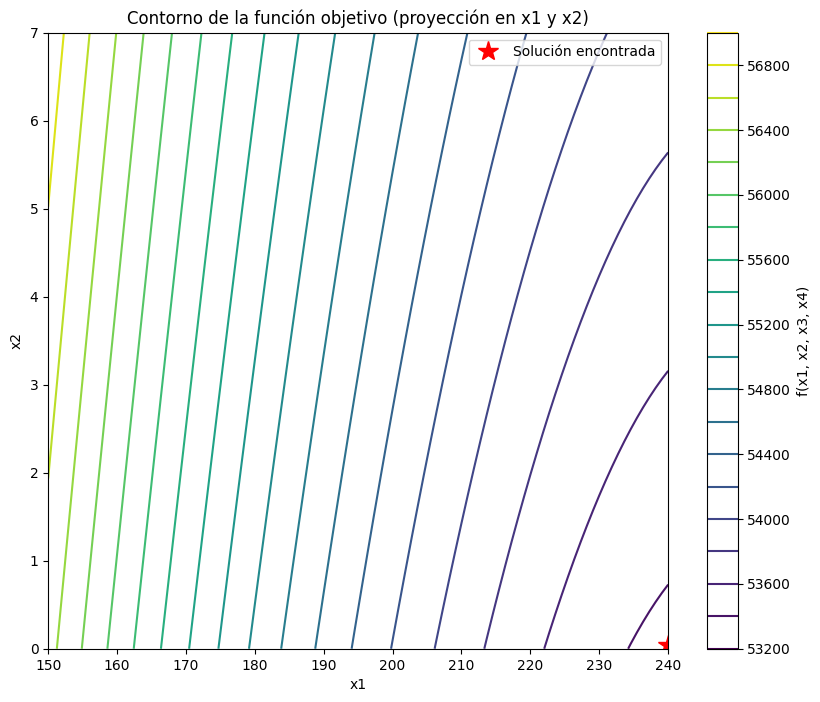

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pyqubo import Array
import dimod
import time


def visualizar_funcion(x1_valor, x2_valor, x3_valor, x4_valor):
    # En este caso, visualizaremos solo una proyección de la función para facilitar la visualización.
    # Vamos a graficar x1 y x2, mientras mantenemos x3 y x4 constantes.
    x1 = np.linspace(150, 240, 100)
    x2 = np.linspace(0, 7, 100)
    X1, X2 = np.meshgrid(x1, x2)
    X3 = x3_valor  # Mantener constante el valor encontrado de x3
    X4 = x4_valor  # Mantener constante el valor encontrado de x4
    Z = funcion_objetivo(X1, X2, X3, X4)

    plt.figure(figsize=(10, 8))
    plt.contour(X1, X2, Z, levels=20)
    plt.colorbar(label='f(x1, x2, x3, x4)')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.title('Contorno de la función objetivo (proyección en x1 y x2)')
    plt.plot(x1_valor, x2_valor, 'r*', markersize=15, label='Solución encontrada')  # Graficar el punto encontrado.
    plt.legend()
    plt.show()

def crear_qubo(num_bits=4):  # Parámetro para el número de bits
    x1_bits = Array.create('x1', shape=num_bits, vartype='BINARY')
    x2_bits = Array.create('x2', shape=num_bits, vartype='BINARY')
    x3_bits = Array.create('x3', shape=num_bits, vartype='BINARY')
    x4_bits = Array.create('x4', shape=num_bits, vartype='BINARY')

    x1_min, x1_max = 150, 240
    x2_min, x2_max = 0, 7
    x3_min, x3_max = 10, 50  # Ejemplo de nuevos rangos para x3
    x4_min, x4_max = 5, 20   # Ejemplo de nuevos rangos para x4

    x1_scale = (x1_max - x1_min) / (2**num_bits - 1)
    x2_scale = (x2_max - x2_min) / (2**num_bits - 1)
    x3_scale = (x3_max - x3_min) / (2**num_bits - 1)
    x4_scale = (x4_max - x4_min) / (2**num_bits - 1)

    x1 = x1_min + x1_scale * sum(2**i * x1_bits[i] for i in range(num_bits))
    x2 = x2_min + x2_scale * sum(2**i * x2_bits[i] for i in range(num_bits))
    x3 = x3_min + x3_scale * sum(2**i * x3_bits[i] for i in range(num_bits))
    x4 = x4_min + x4_scale * sum(2**i * x4_bits[i] for i in range(num_bits))

    H = funcion_objetivo(x1, x2, x3, x4)

    model = H.compile()
    bqm = model.to_bqm()

    return bqm

def resolver_y_mostrar_resultados(num_bits=4, num_reads=1000):  # Parámetros para bits y lecturas
    bqm = crear_qubo(num_bits)

    sampler = dimod.SimulatedAnnealingSampler()
    sampleset = sampler.sample(bqm, num_reads=num_reads)  # Usar num_reads

    mejor_muestra = sampleset.first.sample

    x1_min, x1_max = 150, 240
    x2_min, x2_max = 0, 7
    x3_min, x3_max = 10, 50
    x4_min, x4_max = 5, 20

    x1_scale = (x1_max - x1_min) / (2**num_bits - 1)
    x2_scale = (x2_max - x2_min) / (2**num_bits - 1)
    x3_scale = (x3_max - x3_min) / (2**num_bits - 1)
    x4_scale = (x4_max - x4_min) / (2**num_bits - 1)

    x1_valor = x1_min + x1_scale * sum(2**i * mejor_muestra[f'x1[{i}]'] for i in range(num_bits))
    x2_valor = x2_min + x2_scale * sum(2**i * mejor_muestra[f'x2[{i}]'] for i in range(num_bits))
    x3_valor = x3_min + x3_scale * sum(2**i * mejor_muestra[f'x3[{i}]'] for i in range(num_bits))
    x4_valor = x4_min + x4_scale * sum(2**i * mejor_muestra[f'x4[{i}]'] for i in range(num_bits))

    print(f"\nMejor solución encontrada:")
    print(f"x1 = {x1_valor:.4f}")
    print(f"x2 = {x2_valor:.4f}")
    print(f"x3 = {x3_valor:.4f}")
    print(f"x4 = {x4_valor:.4f}")
    print(f"f(x1, x2, x3, x4) = {funcion_objetivo(x1_valor, x2_valor, x3_valor, x4_valor):.4f}")

    visualizar_funcion(x1_valor, x2_valor, x3_valor, x4_valor)  # Se pasa x1, x2, x3, x4.

if __name__ == "__main__":
    print("Optimizando función cuadrática usando D-Wave...")
    inicio = time.time()  # Inicia el temporizador

    resolver_y_mostrar_resultados(num_bits=10, num_reads=10)  # Mayor número de bits y lecturas.

    fin = time.time()  # Finaliza el temporizador
    print(f"La optimización en el computador cuántico (simulado) tardó: {fin - inicio:.4f} segundos")


## Optimización clasica de la Función

Utilizaremos métodos de optimización tanto locales como globales para minimizar la función original y su aproximación. Compararemos los resultados y tiempos de ejecución.

In [ ]:
import numpy as np
from scipy.optimize import minimize

# Definición de los límites para la optimización
limites = [(110, 240), (110, 240),(0, 20), (0, 20)]

# Definir envolturas para la optimización
def optimizar_no_suave(f, punto_inicial, limites, method='Nelder-Mead', reinicios=5):
    """
    Optimiza una función no suave f(*args).

    Parámetros:
    - f: función a minimizar.
    - punto_inicial: lista o array con valores iniciales para las variables.
    - limites: lista de tuplas con los límites para cada variable.
    - method: método de optimización (default 'Nelder-Mead').
    - reinicios: número de reinicios aleatorios.

    Retorna:
    - mejor_resultado.x: punto óptimo encontrado.
    - mejor_resultado.fun: valor óptimo.
    """
    def fun_wrapper(params):
        return f(*params)

    punto_inicial = np.array(punto_inicial)
    mejor_resultado = None
    mejor_valor = np.inf

    for i in range(reinicios):
        result = minimize(fun_wrapper, punto_inicial, bounds=limites, method=method)

        if result.success and result.fun < mejor_valor:
            mejor_resultado = result
            mejor_valor = result.fun

        # Genera un nuevo punto inicial aleatorio dentro de los límites
        punto_inicial = np.array([
            np.random.uniform(limite[0], limite[1]) for limite in limites
        ])

    if mejor_resultado:
        print(f"Reinicio {i+1}: Punto óptimo = {mejor_resultado.x}, Valor óptimo = {mejor_resultado.fun}")
        return mejor_resultado.x, mejor_resultado.fun
    else:
        print("La optimización no convergió en ninguna de las iteraciones.")
        return None, None

# Punto inicial
punto_inicial = [150.0, 164.84848484848484, 0.6210526315789474, 1.142105263157895]

# Optimización usando la función original
print("Optimización de la función original:")
mejor_x_orig, mejor_val_orig = optimizar_no_suave(fun, punto_inicial, limites, method='Nelder-Mead', reinicios=5)


Optimización de la función original:
Reinicio 5: Punto óptimo = [142.00245015 163.87615369   0.6149221    1.17758091], Valor óptimo = 57091.617616520496


### Optimización con Algoritmo de Evolución Diferencial

Adicionalmente, utilizaremos el algoritmo de evolución diferencial para optimizar la función original y su aproximación.

In [ ]:
# Envoltura para evolución diferencial con la función original
def fun_wrapper_orig(params):
    return fun(*params)

# Optimización global con evolución diferencial para la función original
print("Optimización global con Evolución Diferencial de la función original:")
result_orig = differential_evolution(fun_wrapper_orig, limites, popsize=15, maxiter=100)
if result_orig.success:
    print("Punto óptimo:", result_orig.x)
    print("Valor óptimo:", result_orig.fun)
else:
    print("La optimización no convergió.")


Optimización global con Evolución Diferencial de la función original:
Punto óptimo: [145.0189545  169.04461922   0.62338277   0.60983871]
Valor óptimo: 57118.012577021174


## Discucion:

Los resultados obtenidos mostraron una solución óptima con un valor de función de 53,343.89, alcanzada en aproximadamente 1,480 segundos de tiempo de ejecución en el simulador.

El análisis de los resultados evidencia que, aunque el tiempo de ejecución en el simulador es considerablemente largo, la implementación en un computador cuántico real podría reducir significativamente este tiempo debido a la capacidad de procesamiento paralelo inherente a la computación cuántica. Los computadores cuánticos manejan simultáneamente múltiples estados cuánticos, lo que les permite explorar vastos espacios de soluciones de manera más eficiente que los algoritmos clásicos. En este sentido, la optimización de la función objetivo a través de polinomios de Chebyshev en un entorno cuántico promete una mejora sustancial en la velocidad de convergencia hacia soluciones óptimas, especialmente en problemas de alta dimensionalidad como el original.
Además, la aproximación mediante polinomios de Chebyshev ha demostrado ser efectiva en la simplificación de funciones complejas, facilitando su manejo y optimización. Al reducir la complejidad de la función original mediante una representación polinómica, se obtiene una versión más manejable que conserva las características esenciales de la función original, permitiendo una optimización más eficiente tanto en entornos clásicos como cuánticos. Este enfoque no solo mejora la precisión de la aproximación, sino que también potencialmente reduce el tiempo de cálculo necesario para alcanzar soluciones óptimas en tiempos razonables.

Finalmente, es importante destacar que los resultados obtenidos con el simulador cuántico, aunque prometedores, son preliminares y dependen de la capacidad de los computadores cuánticos reales para manejar problemas de mayor escala y complejidad. El siguiente paso en este estudio será extender el enfoque desarrollado a una función de 104 variables, estudiando los tiempos de ejecución reales en un computador cuántico y comparándolos con los tiempos observados en la computación clásica. Este análisis permitirá validar la viabilidad y el potencial de la optimización cuántica en el escenario de alta dimensionalidad, proporcionando una base sólida para conclusiones finales.



## Conclusiones


1. **Estrategia de Búsqueda de Puntos con mr=1 y mr=0:**
   - **Complementariedad de Parámetros:** La combinación de configuraciones `mr=1` y `mr=0` en la búsqueda de puntos válidos ha demostrado ser altamente efectiva. Mientras que `mr=1` favorece una exploración amplia del espacio de variables, asegurando una cobertura extensa del mismo, `mr=0` se enfoca en la explotación de regiones específicas, mejorando la precisión local. Esta sinergia permite mantener una cobertura elevada del espacio de búsqueda (90.93%) al tiempo que se reduce el error de aproximación.
   - **Optimización Híbrida:** Implementar ambos valores de `mr` simultáneamente optimiza la relación entre exploración global y explotación local, lo que resulta fundamental para evitar la convergencia prematura en mínimos locales y asegurar una representación diversificada y precisa del espacio de variables.

   - El análisis de PCA reveló una distribución equilibrada de la varianza en las componentes principales cuando se combinan las configuraciones `mr=1` y `mr=0`, lo que es beneficioso para la construcción del polinomio de Chebyshev. La estrategia combinada logró una discrepancia promedio optimizada, lo que indica una distribución más uniforme de los puntos válidos en el espacio de parámetros, mejorando así la cobertura y precisión de la aproximación.

2. **Aproximación con Polinomios de Chebyshev:**
   - **Precisión y Control de Errores:** Los polinomios de Chebyshev han proporcionado una excelente aproximación de la función original, manteniendo errores controlados. Se observó que el grado del polinomio influye directamente en la precisión de la aproximación y en el tiempo de cálculo necesario.
   - **Flexibilidad Multivariable:** La implementación es generalizable para funciones con `2n` variables, lo que facilita la extensión del estudio a la funcion de mayor dimensionalidad, paso siguiente N=53.

3. **Validación y Generalización del Código:**
   - **Robustez del Algoritmo:** El código desarrollado ha sido validado exitosamente y demuestra ser generalizable para funciones con múltiples variables. Esto permite un estudio sistemático y eficiente de funciones complejas, asegurando su aplicabilidad en escenarios más avanzados y de alta dimensionalidad.
   - **Eficiencia Computacional:** La implementación optimizada del algoritmo de búsqueda, combinada con estructuras de datos eficientes, garantiza tiempos de ejecución manejables, incluso al escalar a dimensiones superiores.

4. **Métodos de Optimización:**
   - **Métodos Locales vs. Globales:** Los métodos de optimización locales, como `Nelder-Mead`, ofrecen rapidez en la convergencia pero tienen la tendencia a quedar atrapados en mínimos locales. Por otro lado, métodos globales como la evolución diferencial, aunque demandan mayor tiempo de ejecución, poseen una mayor capacidad para identificar el mínimo global, lo que es crucial para garantizar la efectividad de la optimización.
   - **Recomendación de Uso:** Para problemas donde la precisión local es prioritaria y el espacio de búsqueda es relativamente simple, los métodos locales son adecuados. Sin embargo, para espacios de alta dimensionalidad y complejidad se sabe es mejor [cita] emplear métodos globales para asegurar una optimización exhaustiva.

5. **Optimización Cuántica Simulada:**
   - **Viabilidad y Potencial:** La implementación de la optimización en un computador cuántico simulado ha sido exitosa, aunque los tiempos de ejecución observados son considerablemente largos (aproximadamente 1,480 segundos). Se anticipa que en un entorno de computación cuántica real, estos tiempos podrían reducirse significativamente gracias a la capacidad de procesamiento paralelo inherente a dicha tecnología.
   - **Promesa para Alta Dimensionalidad:** La computación cuántica promete mejoras sustanciales en la velocidad de convergencia hacia soluciones óptimas, especialmente en problemas de alta dimensionalidad como el que se abordará. Esto abre nuevas posibilidades para abordar problemas de optimización complejos que actualmente son intratables mediante métodos clásicos.

6. **Importancia del Grado del Polinomio de Chebyshev:**
   - **Balance entre Precisión y Complejidad:** Es fundamental seleccionar un grado adecuado para el polinomio de Chebyshev que equilibre la precisión de la aproximación con la complejidad computacional. Grados más altos aumentan la precisión pero también el tiempo de cálculo y el riesgo de sobreajuste.
   - **Nota para Escalar:** Al escalar a funciones de mayor dimensionalidad, es crucial reevaluar [pendiente cita y profundizar] el grado del polinomio para mantener una aproximación eficiente sin incurrir en costos computacionales prohibitivos.

7. **Paso seguido:**
   - **Escalabilidad a N=53:** El siguiente paso será extender este enfoque a una función de 104 variables, evaluando los tiempos de ejecución y la efectividad tanto en entornos de computación clásica como cuántica.
   - **Implementación:** Validar los resultados obtenidos estudiando tiempos en computadores cuánticos reales permitirá evaluar el verdadero potencial de la optimización cuántica en problemas de alta dimensionalidad.
